# How cold was the ice age ocean?
This notebook uses climate model outputs to answer a simple question: how cold was the ocean during the last ice age? It's divided into two parts, the first introduces and accesses climate model data from the Coupled Model Intercomparison Project (CMIP). The second plots and performs some basic analysis on the model data.

----
## 1. Search, access, and download Coupled Model Intercomparison Project (CMIP) and Paleoclimate Model Intercomparison Project (PMIP)
A large part of our collective understanding of the climate system and its response to natural and unnatural forcing comes from simulations by climate models. While models allow us the freedom to test atmopshere, ocean, and cryosphere conditions under a variety of climate scenarios, including under various future emmissions scenarios and orbital and radiative forcing configurations from the geological past, they are also hindered by biases and uncertainties inherent in any attempt to condense the complexities of the natural world into lines of code. 

The Coupled Model Intercomparison Project (CMIP) developed as an international collaboration between climate modellers wherein consistent experiments (with identidical boundary conditions and forcing trajectories) are performed simultaneously by multiple different climate models. The idea being that biases and uncertaintities inherent to the particulars of each model will _come out in the wash_ when we consider the common findings across all the models. 

![](https://esgf-node.llnl.gov/site_media/logos/cmip5_100.png)

The CMIP initiative now has several offshoots, such as the Paleocliamte Model Intercomparison Project (PMIP). In PMIP, experiments are performed by multiple different modelling groups following the same boundary conditions, usually represting a given period in Earth's past (i.e. the mid Holocene, the Last Glacial Maximum, etc.). These experiments are extremely useful in helping us understand the nature of natural variability in the climate system; providing a comparison against which to recognise unnatural trajectories in the modern system. An important baseline for these experiments is the Pre-Industrial Control experiment, which provides an equilibrium state for the ocean-atmosphere-ice conditions under modern boundary conditions in the absence of anthropogenic warming.

### This Notebook
In part 1 of this notebook, I show how easy it is to query, access, and load climate model output files from the CMIP (and this in this case PMIP) initiatives. CMIP is now in it's 6th phase (CMIP6) and PMIP it's 4th (PMIP4), however for various reasons (notably a more complete suite of PMIP3 model contributions) I here show how to find CMIP5 and PMIP3 experiments. After finding out which models meet my criteria (e.g. all the models which have _ocean temperature_ outputs available from a _Last Glacial Maximum_ **and** _PiControl_ experiments), I will open the data in `Xarray`, merge the data, and save them as netCDF files for posterity.

### Tools
Luckily for us, the Earth System Grid Federation (ESGF) provides an easy to access database of standardised CMIP datasets, which we can access via the `PyESGF` module. The ESGF Python client allows us to interact with the ESGF system and search for files on one of the available data servers. _One note here is that you need an ESGF OpenID to access the servers (this is free to sign up for [here](https://esgf-data.dkrz.de/user/reminder/))_

In the accompanying file `pymip_fun.py`, I define some functions using `PyESGF` to connect to the ESGF system and search for models with the desired experiments and variables. A full list of the nonemclature and available variables can be found [here](https://pcmdi.llnl.gov/mips/cmip5/datadescription.html). 



In [3]:
cd '/Users/starr/My Drive/Files/Code Bin/datasci_portfolio/PyMIP'

/Users/starr/My Drive/Files/Code Bin/datasci_portfolio/PyMIP


In [4]:
### import libraries
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pymip_fun import search_pmip, get_pmip

In [5]:
%load_ext autoreload
%autoreload 2

### 1. Testing the `search_pmip` function
- Here I search for all of the PMIP3 models which have `thetao` (ocean potential temperature) data available for LGM and Pre-Industrial control experiments. 
- for `search_pmip`, one just needs to give the variable of interest and the experiment name. 
- the function returns a `context` object which we extract the model keys from to populate a list of models that meet the criteria. 

In [9]:
variabl = 'thetao' # select the CMIP variable to search/download (uo = eastward velocity)
modelz_lgm = search_pmip(variabl, 'lgm').facet_counts['model'].keys() # search for models with variable uo from experiment LGM 
modelz_pi = search_pmip(variabl,'piControl').facet_counts['model'].keys() # search for models with variable uo from PIcontrol experiment 
modelz_lgm = set(modelz_lgm) # convert to sets to use intersection
modelz_pi = set(modelz_pi) # convert to sets to use intersection

model_avail=[]
for name in modelz_lgm.intersection(modelz_pi):
    model_avail.append(name) # create a list of every model with variabl available for BOTH pi and lgm
    
print('these are the models which meet the criteria:\n'+str(model_avail))

these are the models which meet the criteria:
['CNRM-CM5', 'MPI-ESM-P', 'GISS-E2-R', 'MIROC-ESM', 'CCSM4', 'FGOALS-g2', 'MRI-CGCM3']


## 2. Pull the OpenDAP urls for each dataset
- the context object from pyESGF actually returns the url we need to access the file as a netCDF
- this can be read directly into Xarray!

In [148]:
%%capture --no-display
## note I'm supressing the output from this cell to avoid an annoying warning message which is escaping the warnings.filter method...

experimen='piControl'
urlz_pi = []
for modl in model_avail:
    urlz_pi.append(get_pmip(variabl,experimen,modl))

experimen='lgm'
urlz_lgm = []
for modl in model_avail:
    urlz_lgm.append(get_pmip(variabl,experimen,modl))


In [149]:
print('These are the URLs for the desired datasets:\n'+str(urlz_lgm))

These are the URLs for the desired datasets:
['http://vesg.ipsl.upmc.fr/thredds/dodsC/pmip3/output/CNRM-CERFACS/CNRM-CM5/lgm/monClim/ocean/Oclim/r1i1p1/v20140428/thetao/thetao_Oclim_CNRM-CM5_lgm_r1i1p1_180001-199912-clim.nc', 'http://vesg.ipsl.upmc.fr/thredds/dodsC/pmip3/output/MPI-M/MPI-ESM-P/lgm/monClim/ocean/Oclim/r1i1p1/v20140428/thetao/thetao_Oclim_MPI-ESM-P_lgm_r1i1p1_185001-194912-clim.nc', 'http://vesg.ipsl.upmc.fr/thredds/dodsC/pmip3/output/NASA-GISS/GISS-E2-R/lgm/monClim/ocean/Oclim/r1i1p151/v20140428/thetao/thetao_Oclim_GISS-E2-R_lgm_r1i1p151_300001-309912-clim.nc', 'http://vesg.ipsl.upmc.fr/thredds/dodsC/pmip3/output/MIROC/MIROC-ESM/lgm/monClim/ocean/Oclim/r1i1p1/v20140428/thetao/thetao_Oclim_MIROC-ESM_lgm_r1i1p1_460001-469912-clim.nc', 'http://vesg.ipsl.upmc.fr/thredds/dodsC/pmip3/output/NCAR/CCSM4/lgm/monClim/ocean/Oclim/r2i1p1/v20190313/thetao/thetao_Oclim_CCSM4_lgm_r2i1p1_187001-190012-clim.nc', 'http://vesg.ipsl.upmc.fr/thredds/dodsC/pmip3/output/LASG-CESS/FGOALS-g2/lg

In [23]:
## login to the ESGF sever using my OpenID
from pyesgf.logon import LogonManager
lm = LogonManager()
lm.logoff()
lm.is_logged_on()
lm.logon(hostname='esgf-node.llnl.gov', interactive=True, bootstrap=True)
lm.is_logged_on()

Enter myproxy username: 

 aidan.starr@marine.rutgers.edu
Enter password for aidan.starr@marine.rutgers.edu:  ········


True

### Taking the time-averaged data
- now that I have the urls, I can load the data into xarray dataframes
- load into xarray using dask 'chunks' to parallelize the process 
- then, I can take the mean along the time axis (I'm only interested in the annually-averaged data here)
- loop through and do this for each pi and lgm file

In [ ]:
%%capture --no-display
## note I'm supressing the output from this cell to avoid an annoying warning message which is escaping the warnings.filter method...

### open the PI datasets in xarray and take the 
thetao_pi = {}
thetao_lgm = {}
countr = -1

for modl in model_avail:
    countr=countr+1
    thetao_pi[modl] = xr.open_dataset(urlz_pi[countr], decode_times=False) # open pi file
    thetao_lgm[modl] = xr.open_dataset(urlz_lgm[countr], decode_times=False) # open lgm file
    thetao_pi[modl] = thetao_pi[modl].mean('time').rename({'thetao':'thetao_pi'})# take time average and rename the variable to be uo_pi
    thetao_lgm[modl] = thetao_lgm[modl].mean('time').rename({'thetao':'thetao_lgm'})# take time average and rename the variable to be uo_pi

### Merging the lgm and pi variables
- At this point, I have time-averaged `uo` data for each model from both experiments
- Now I want to merge the lgm and pi experiments into a single xarray dataframe
- I've already renamed the variable, and both files per model are alreadt on the same grid
- so they can be merged directly using `xr.merge`

In [ ]:
merged_xrs = {}
for modl in model_avail:
    merged_xrs[modl] = xr.merge([thetao_pi[modl],thetao_lgm[modl]],compat='override')
    
    ### also save the new merged dataframes to netcdf for posterity
    filename = str(modl + '_originalgrid_lgm_pi.nc')
    merged_xrs[modl].to_netcdf('files/'+filename)
    

----
## Part 2: From netcdf to pretty plots
Now I have the netcdfs for each model downloaded, I can go ahead and find the mean temperature (both whole ocean and surface ocean) for Pre-Industrial and LGM boundary conditions.


In [6]:
## additional modules for plotting
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [81]:
### load model data and tidy up a little (for now, just load 3 models)

# -- MIROC -- #
miroc = xr.open_dataset('files/MIROC-ESM_originalgrid_lgm_pi.nc')
for va in ['thetao_pi','thetao_lgm']:
    miroc[va] = miroc[va]-273.15 # convert Kelvin to degrees celcius
miroc['delta_thetao'] = miroc['thetao_lgm']-miroc['thetao_pi'] # find difference in temperature between LGM and Preindustrial 

# -- MPI-ESM -- #
mpi = xr.open_dataset('files/MPI-ESM-P_originalgrid_lgm_pi.nc')
for va in ['thetao_pi','thetao_lgm']:
    mpi[va] = mpi[va]-273.15 # convert Kelvin to degrees celcius
mpi['delta_thetao'] = mpi['thetao_lgm']-mpi['thetao_pi'] # find difference in temperature between LGM and Preindustrial 


# -- CNRM-CM5 -- #
cnrm = xr.open_dataset('files/CNRM-CM5_originalgrid_lgm_pi.nc')
for va in ['thetao_pi','thetao_lgm']:
    cnrm[va] = cnrm[va]-273.15 # convert Kelvin to degrees celcius
cnrm['delta_thetao'] = cnrm['thetao_lgm']-cnrm['thetao_pi'] # find difference in temperature between LGM and Preindustrial 


# -- GISS-E2-R -- #
giss = xr.open_dataset('files/GISS-E2-R_originalgrid_lgm_pi.nc')
for va in ['thetao_pi','thetao_lgm']:
    giss[va] = giss[va]-273.15 # convert Kelvin to degrees celcius
giss['delta_thetao'] = giss['thetao_lgm']-giss['thetao_pi'] # find difference in temperature between LGM and Preindustrial 


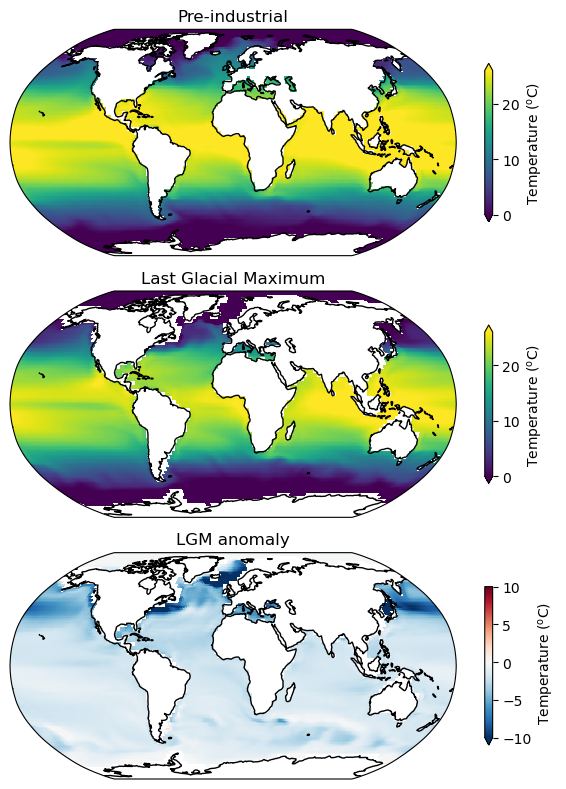

In [42]:
### Plot of a map of PI, LGM, and LGM-PI temperature from the MIROC-ESM model as an example
projection = ccrs.Robinson() # set the map projection ot be Robinson (nice to look at)

## setup subplots
f, ax = plt.subplots(3,1,subplot_kw=dict(projection=projection),figsize=(6,8))

# PI
miroc.isel(lev=0)['thetao_pi'].plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(shrink=0.7,label='$\mathrm{Temperature\ (^oC)}$'),ax=ax[0],vmax=26,vmin=0,cmap='viridis')
ax[0].coastlines()
ax[0].set_title('Pre-industrial')

# LGM
miroc.isel(lev=0)['thetao_lgm'].plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(shrink=0.7,label='$\mathrm{Temperature\ (^oC)}$'),ax=ax[1],vmax=26,vmin=0,cmap='viridis')
ax[1].coastlines()
ax[1].set_title('Last Glacial Maximum')

# anomaly
miroc.isel(lev=0)['delta_thetao'].plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(shrink=0.7,label='$\mathrm{Temperature\ (^oC)}$'),ax=ax[2],vmin=-10,vmax=10,cmap='RdBu_r')
ax[2].coastlines()
ax[2].set_title('LGM anomaly')


plt.tight_layout()

### Weighted averages
An important feature to note here is that the grid cells in each model are not uniform in size. This means that we can't just take the average of every cell (i.e. unweighted average). Instead, we need to take an **area-weighted** average. Fortunately, each CMIP model provides a gridded file with the area of each grid cell called `areacello`. 

In the `files/` folder of this directory, I've already got this area data for each model from a previous project. _Note that it would be possible to simply use 'areacello' as the search variable in the search_pmip and get_pmip functions from part 1 of this notebook._


In [65]:
### for now, I will focus on 3 models 
cnrm_area = xr.open_dataset('files/CNRM-CM5_areacello.nc')
miroc_area = xr.open_dataset('files/MIROC-ESM_areacello.nc')
mpi_area = xr.open_dataset('files/MPI-ESM-P_areacello.nc')
giss_area = xr.open_dataset('files/GISS-E2-R_areacello.nc')


In [83]:
from pymip_fun import area_weighted_average # improt area weighted average function

pmip3_temps = pd.DataFrame(columns=['Model','Experiment','Surface Temperature'],index=range(0,7))


## surface ocean average
miroc_surface_pi = area_weighted_average(miroc.isel(lev=0)['thetao_pi'],['lon','lat'],miroc_area['areacello'])
pmip3_temps.loc[0]={'Model':'MIROC-ESM','Experiment':'PI','Surface Temperature':miroc_surface_pi.values}

miroc_surface_lgm = area_weighted_average(miroc.isel(lev=0)['thetao_lgm'],['lon','lat'],miroc_area['areacello'])
pmip3_temps.loc[1]={'Model':'MIROC-ESM','Experiment':'LGM','Surface Temperature':miroc_surface_lgm.values}

cnrm_surface_pi = area_weighted_average(cnrm.isel(lev=0)['thetao_pi'],['j','i'],cnrm_area['areacello'])
pmip3_temps.loc[2]={'Model':'CNRM-CM5','Experiment':'PI','Surface Temperature':cnrm_surface_pi.values}
cnrm_surface_lgm = area_weighted_average(cnrm.isel(lev=0)['thetao_lgm'],['j','i'],cnrm_area['areacello'])
pmip3_temps.loc[3]={'Model':'CNRM-CM5','Experiment':'LGM','Surface Temperature':cnrm_surface_lgm.values}

mpi_surface_pi = area_weighted_average(mpi.isel(lev=0)['thetao_pi'],['j','i'],mpi_area['areacello'])
pmip3_temps.loc[4]={'Model':'MPI-ESM-P','Experiment':'PI','Surface Temperature':mpi_surface_pi.values}
mpi_surface_lgm = area_weighted_average(mpi.isel(lev=0)['thetao_lgm'],['j','i'],mpi_area['areacello'])
pmip3_temps.loc[5]={'Model':'MPI-ESM-P','Experiment':'LGM','Surface Temperature':mpi_surface_lgm.values}


giss_surface_pi = area_weighted_average(giss.isel(lev=0)['thetao_pi'],['lat','lon'],giss_area['areacello'])
pmip3_temps.loc[6]={'Model':'GISS-E2-R','Experiment':'PI','Surface Temperature':giss_surface_pi.values}
giss_surface_lgm = area_weighted_average(giss.isel(lev=0)['thetao_lgm'],['lat','lon'],giss_area['areacello'])
pmip3_temps.loc[7]={'Model':'GISS-E2-R','Experiment':'LGM','Surface Temperature':giss_surface_lgm.values}

# convert from object to float
pmip3_temps['Surface Temperature'] = pmip3_temps['Surface Temperature'].astype(float)


Text(64.25, 0.5, 'Sea Surface Temp. (ºC)')

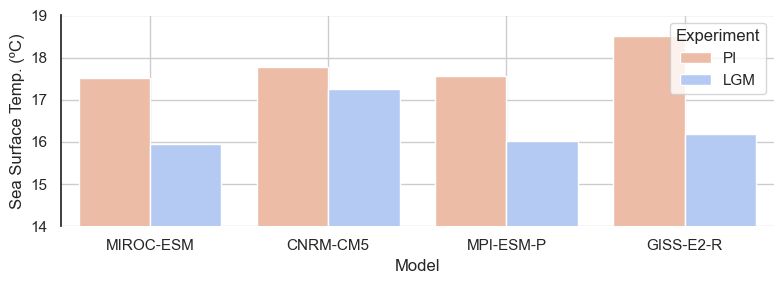

In [119]:
import seaborn as sns
sns.set_theme(style="white", context="notebook")

f,ax = plt.subplots(1,1,figsize=(8,3))
sns.barplot(data=pmip3_temps, x="Model", y="Surface Temperature", hue="Experiment",palette='coolwarm_r',ax=ax,alpha=1)
ax.set_ylim(14,19)
ax.grid('x')
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)
ax.set_ylabel('Sea Surface Temp. (ºC)')



In [146]:
pmip3_temps.groupby('Experiment').mean()


/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_27721/2805906797.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pmip3_temps.groupby('Experiment').mean()


,Surface Temperature
Experiment,
LGM,16.353247
PI,17.846521
